In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# GLOBAL DECLEARATIONS

In [0]:
import datetime
import os
import numpy as np
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.ticker as ticker
# dbname_mat folders exist here
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DATA DIR :: '+global_dir)

# dbname_npy shoud exsist
global_npydir = os.path.join(global_dir, 'db_npy') #global_dir + 'db_npy/'
print('GLOBAL NPY DIR :: '+global_npydir)

global_datadir = os.path.join(global_npydir, 'data_npy') 
print('GLOBAL DATA DIR :: '+global_datadir)

# global annotation and mapping, common for all ECG from https://physionet.org/about/database/
global_annot = os.path.join(global_dir, 'annotations.txt' )  
print('GLOBAL ANNOTATIONS :: '+global_annot)
# view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo

#===================================================================================================================
# load MIT annotation mapping  

g_MIT_AMAP_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_MIT_AMAP={}
for a in g_MIT_AMAP_data:
    g_MIT_AMAP[a[0]]= int(a[1])
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)

map_keys = g_MIT_AMAP.keys()
map_vals = g_MIT_AMAP.values()

print(map_keys)
print(' :: STD LABEL MAPPING :: ')
for k in map_keys:
    print(k+'\t'+str(g_MIT_AMAP[k]))
#print(g_MIT_AMAP)

maxlabels=max(map_vals)+1
print('Max DB Label = '+ str(maxlabels))

g_COLORS = ['green','gold','red']
g_LABELS = np.array(['N','B','A'])
g_COUNT = len(g_LABELS)
print('STD Labels : ' + str(g_LABELS))
print('MAX STD Label = '+ str(g_COUNT))
#===================================================================================================================

print(datetime.datetime.now())


GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
dict_keys(['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?', '[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', "'", '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@'])
 :: STD LABEL MAPPING :: 
N	0
L	1
R	1
B	1
A	2
a	2
J	2
S	2
V	2
r	2
F	2
e	2
j	2
n	2
E	2
/	-1
f	-1
Q	2
?	-1
[	-2
!	2
]	-2
x	-2
(	-2
)	-2
p	-2
t	-2
u	-2
`	-2
'	-2
^	-2
|	-2
~	-2
+	-2
s	-2
T	-2
*	-2
D	-2
=	-2
"	-2
@	-2
Max DB Label = 3
STD Labels : ['N' 'B' 'A']
MAX STD Label = 3
2020-02-23 20:00:39.681500


# CLASS DEFINITIONS

In [0]:

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        #self.dirs = db.get_dirs(recname)            # dict              dict of npy data file names to be loaded in data dict used in self.load_data('key')
        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')

        # find the gain
        info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'),db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(info[2].split('/')[0])
        #print(self.info)
        
    def read_data(self, data_type):
        return self.data[data_type] #= np.load(self.dirs[s])

    def load_data(self, data_type):
        self.data[data_type] = np.load(os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy'))
        return self.data[data_type]

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_dir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        return ecg_record(self,rec)

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    if res % 2 == 0 : # is even
        res+=1 # make odd
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path, minfo_line_index):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return la # gain at 2 baseline at 4

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tKnown\tUnknown' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsnpy = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            if (a_label in map_keys):
                antsnpy = np.vstack((antsnpy,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsnpy))+'\t' + str(adf) )
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix+'.npy'), antsnpy)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 2 Map Annotations :: ant.npy -> antm.npy
def map_db_ants(self_db, g_map, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    #global g_MIT_AMAP
    xs=len(self_db.recs)
    #xc=1
    print('\nTASK :: MAP annotations for ' + str(xs)+ ' records :: using prefix '+ '*_'+output_postfix+'.npy')
    print('REC\tFound\tMapped\tUnmapped' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1

        ants = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy'))

        #print('\tFound Annotations\t'+str(len(ants)))
        antsmap = np.zeros((0,2),dtype='int')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_sample = int(ants[i][0])
            a_label = g_map[ants[i][1]]
            if a_label>=0:
                antsmap = np.vstack((antsmap, np.array([a_sample,a_label])))

        adf =  len(ants) - len(antsmap) 
        #print('\tMapped Annotations\t'+str(len(antsmap)))
        #print('\tUnmapped Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsmap))+'\t' + str(adf) )
        # save for this record
        np.save(os.path.join(  self_db.dir_npy , rec + '_'+output_postfix+'.npy'), antsmap)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: MAP annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    print('\nBEGIN TASK :: Save lead2 signal data for ' + str(xs)+ ' records')
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val'][self_db.lead2_index]
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'), mat_signal)    
    print('END TASK :: Save lead2 signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 4 Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer lead2 signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer lead2 signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 5 Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    
    print('\nBEGIN TASK :: denoising lead2 signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising lead2 signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------


# DB DICT CREATION

In [0]:
# def __init__(self, dbname,  sampling_rate, lead2_index):
all_db = {}
all_db['mitdb'] = ecg_db('mitdb', 360, 0)
all_db['svdb'] = ecg_db('svdb',  128, 0)
all_db['incartdb'] = ecg_db('incartdb', 257, 1)
#print(all_db.values())
print('')
print(all_db.keys())


g_MIT_AMAP_POSTFIX = 'ant_m'
g_ANT_POSTFIX = 'ant'
g_RAW_POSTFIX = 'raw2'
g_MED_POSTFIX = 'med2'
g_DEN_POSTFIX = 'den2'
g_RMD_POSTFIX = 'rmd2'
g_RDM_POSTFIX = 'rdm2'



Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
RECORD SET :: [48] {'121', '217', '202', '207', '112', '210', '221', '105', '115', '107', '222', '215', '208', '100', '123', '233', '219', '119', '201', '212', '111', '108', '200', '213', '114', '220', '116', '232', '101', '205', '231', '102', '234', '230', '118', '104', '106', '122', '103', '117', '228', '223', '209', '124', '109', '214', '203', '113'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
RECORD SET :: [78] {'867', '843', '801', '823', '842', '886', '826', '859', '822', '828', '844', '855', '884', '874', '890', '851', '865', '809', '848', '829', '841', '883', '885', '887', '

# VIEW Section

In [0]:


idbs = 'mitdb'  # 'mitdb'  'svdb' 'incartdb'
irec = '219'
dbs = all_db[idbs]
selrec = dbs.get_record(irec)
manual_gain=1/selrec.gain

# VIEW 1 :: RECORD

In [9]:


# extract annotations ==================================================================================
ant2 = selrec.load_data(g_ANT_POSTFIX)       # all annotations
ant2m = selrec.load_data(g_MIT_AMAP_POSTFIX) # only has mapr>=0 {no umapped beats preset}

ant_s = ant2[:,0].astype('int')
ant_l = ant2[:,1]

ant_sm = ant2m[:,0]
ant_lm = ant2m[:,1]


# plot record annotations ==================================================================================
plt.figure(0, figsize=(240,4),dpi=100)
plt.ylim(-0.2*g_COUNT-1, 1.5 )
plt.xlim(-10, 1830 )
aa = plt.axes()
ax = aa.get_xaxis()
ay = aa.get_yaxis()
ax.set_major_locator(ticker.MultipleLocator(5))
ay.set_visible(False)
plt.grid(axis='x' )

for gi in range(0,g_COUNT):
    samp_dict = ant_sm[ant_lm==gi]
    plt.scatter(np.multiply(samp_dict,[1/dbs.srate]),np.subtract(np.multiply(ant_lm[ant_lm==gi],[-0.2]),1),color=g_COLORS[gi],marker='.',label=g_LABELS[gi]+' ['+str(len(samp_dict))+']')


#------------------------------ CUSTOM ANOTATIONS HERE ------------------------------
#cust_label = 'Q'
#ps_x = np.multiply(ant_s[ant_l==cust_label],[1/dbs.srate])
#ps_y = np.subtract(np.zeros(len(ant_l[ant_l==cust_label])),[0.75])
#plt.scatter(ps_x,ps_y,color='blue',marker='o',label='Custom: ' + cust_label+' ['+str(len(ps_x))+']')
#------------------------------ CUSTOM ANOTATIONS HERE ------------------------------


#------------------------------ NON BEAT ANOTATIONS HERE ------------------------------
ps_x = np.multiply(ant_s[ant_l=='x'],[1/dbs.srate])
ps_y = np.subtract(np.zeros(len(ant_l[ant_l=='x'])),[0.25])
plt.scatter(ps_x,ps_y,color='black',marker='x',label='Non-Cond P-wave'+' ['+str(len(ps_x))+']')

ps_x = np.multiply(ant_s[ant_l=='|'],[1/dbs.srate])
ps_y = np.subtract(np.zeros(len(ant_l[ant_l=='|'])),[0.25])
plt.scatter(ps_x,ps_y,color='black',marker='|',label='QRS-like complex'+' ['+str(len(ps_x))+']')

ps_x = np.multiply(ant_s[ant_l=='~'],[1/dbs.srate])
ps_y = np.subtract(np.zeros(len(ant_l[ant_l=='~'])),[0.5])
plt.scatter(ps_x,ps_y,color='red',marker='x',label='~Quality change~'+' ['+str(len(ps_x))+']')

ps_x = np.multiply(ant_s[ant_l=='"'],[1/dbs.srate])
ps_y = np.subtract(np.zeros(len(ant_l[ant_l=='"'])),[0.5])
plt.scatter(ps_x,ps_y,color='black',marker='+',label='Commnet'+' ['+str(len(ps_x))+']')

ps_x = np.multiply(ant_s[ant_l=='+'],[1/dbs.srate])
ps_y = np.subtract(np.zeros(len(ant_l[ant_l=='+'])),[0.5])
plt.scatter(ps_x,ps_y,color='green',marker='>',label='Rhythm change'+' ['+str(len(ps_x))+']')
#------------------------------ NON BEAT ANOTATIONS HERE ------------------------------


# get N B A density ==================================================================================
den_N = np.zeros((1800,3),dtype=float) #density in 10 ms window
for i in range(0, len(den_N)):
    temp = ant2m[(ant_sm>(i-5)*selrec.db.srate) & (ant_sm<(i+5)*selrec.db.srate)] [:,1]
    den_N[i,0]=len(temp[temp==0]) / len(temp) 
    den_N[i,1]=len(temp[temp==1]) / len(temp)  
    den_N[i,2]=len(temp[temp==2]) / len(temp)  

# plot density
plt.plot(den_N[:,0],color= 'green',linewidth=0.8)
plt.plot(den_N[:,1],color= 'gold',linewidth=0.8)
plt.plot(den_N[:,2],color= 'red',linewidth=0.8)
# get N B A density ==================================================================================


plt.title(selrec.name + ':: Total peaks = '+str(len(ant2m)))
plt.legend()

plt.savefig('/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_png/'+selrec.name +'.png')
plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


# VIEW 2 :: VIEW SAVE

In [0]:

# randomly build these arrays for a select set of records

time_start = np.array(  [10, 1770]    ) 


#============ select interval start times in seconds
time_safe = 3
time_period = 10 

#============ define some figure parameters
x_scale = 25 * 0.04  # 25 mm or 1 inches  per second
y_scale = 10 * 0.04  # 10 mm or 0.4 inches  per mV
m_scale = 2          # multiplier (zoom)
fylims = (-2.5,2.5) #mV
fhig = (fylims[1]-fylims[0]) * y_scale * m_scale
fwid = time_period * x_scale * m_scale
lysize = (fwid,fhig*1) #secods

#============ load signals only if needed
#signalraw2 = selrec.read_data(g_RAW_POSTFIX)
signalmed2 = selrec.load_data(g_MED_POSTFIX)
#signalden2 = selrec.load_data(g_DEN_POSTFIX)
#signalrmd2 = selrec.load_data(g_RMD_POSTFIX)
#signalrdm2 = selrec.load_data(g_RDM_POSTFIX)

L = len(signalmed2)

#-------------------------------------------------------------------------------------------------------
desc = ''
desc += 'REC\t'+ str(selrec.name) + '\n'
#desc += 'Time\t'+ str(time_start) + ' : ' +str(time_start+time_period) +'\n'
desc += 'Params\tX='+ str(x_scale) + ' in/sec, Y='+str(y_scale)+' in/mV'+', Multiplier=' +str(m_scale)+ '\n'
desc += 'Params\tY-RANGE='+str(fylims)+' mV, Manual_Gain='+str(manual_gain)+'\n'
print(desc)
#-------------------------------------------------------------------------------------------------------



time_safe_samps = time_safe*dbs.srate
time_period_samps = time_period*dbs.srate
time_start_samps = np.multiply(time_start,[dbs.srate])
allfig = 0

save_these = []
for tstart in time_start_samps:
    fi = (tstart)
    ti = (tstart+time_period_samps)
    save_prefix = selrec.name+'_'+str(fi)+'_'+str(ti)       # name = dbname_rec_fi_ti
    if fi<0 or ti>L:
        print ('Beyond Limits : can not form this view')
        continue

    # copy signals only if needed
    #fsignalraw2 = np.multiply(signalraw2[fi:ti],[manual_gain])
    #fsignalmed2 = np.multiply(signalmed2[fi:ti],[manual_gain])
    #fsignalden2 = np.multiply(signalden2[fi:ti],[manual_gain])
    #fsignalrmd2 = np.multiply(signalrmd2[fi:ti],[manual_gain])
    #fsignalrdm2 = np.multiply(signalrdm2[fi:ti],[manual_gain])

    # ----------visual figure------------------------------------------------------------------------------------------------
   
    #plt.figure(allfig,figsize=lysize, frameon=False, dpi=100)
    

    #plt.ylim(fylims)
    #plt.xlim((0,ti-fi))
    #plt.axes().get_yaxis().set_visible(False)
    #plt.grid(axis='x')

    # plot signals
    #plt.plot(fsignalmed2,linewidth=0.2,color='blue', label = 'med')
    #plt.plot(fsignalrmd2,linewidth=0.2,color='green', label = 'rmd2')

    # plot annotations as ticks
    #ar_s = np.subtract(ant_s[(ant_s>=fi) & (ant_s<ti)], fi)#[1:-1] # skip first and last R peak
    #ar_l = ant_l[(ant_s>=fi) & (ant_s<ti)]#[1:-1] # skip first and last R peak
    #plt.xticks(ar_s,ar_l)
    #plt.title(str(allfig)+' '+save_prefix)
    ##plt.legend()
    # ----------visual figure------------------------------------------------------------------------------------------------


    #----------vinfo annotations array------------------------------------------------------------------------------------------------
    # no need to select which signal to save - just save the time limits, signal will be extract realtime
    # select annotations to save as labels====================================
    ar_sm = np.subtract(ant_sm[(ant_sm>=fi) & (ant_sm<ti)], fi)
    ar_lm = ant_lm[(ant_sm>=fi) & (ant_sm<ti)]

    if ar_sm[1] < time_safe_samps: # 1st beat is below 3 sec mark -> skip it
        ar_sm = ar_sm[1:] # skip first and last R peak
        ar_lm = ar_lm[1:]

    if ar_sm[-1] > time_period_samps - time_safe_samps:
        ar_sm = ar_sm[:-1] # skip first and last R peak
        ar_lm = ar_lm[:-1]

    vinfo = np.transpose(np.vstack((ar_sm,ar_lm)))    
    #print(vinfo)
    print(str(allfig) + '\t' + str(vinfo.shape)+'\t' + save_prefix  )
    #print(len(vinfo))

    save_these.append( [ os.path.join(global_datadir,save_prefix+'_vi.npy'), vinfo ] )
    #np.save(os.path.join(global_datadir,save_prefix+'_vi.npy'), vinfo)
    #plt.savefig(os.path.join(global_datadir,save_prefix+'_vinfo.png'))
    allfig+=1


REC	incartdb_I48
Params	X=1.0 in/sec, Y=0.4 in/mV, Multiplier=2
Params	Y-RANGE=(-2.5, 2.5) mV, Manual_Gain=0.0009606147934678194

0	(11, 2)	incartdb_I48_2570_5140
1	(10, 2)	incartdb_I48_454890_457460


In [0]:
save_these_i =  np.arange(0, len(save_these), 1)

for i in save_these_i:
    st = save_these[i]
    np.save(st[0],st[1])
    print('saved '+ str(st[0]))


saved /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy/incartdb_I48_2570_5140_vi.npy
saved /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy/incartdb_I48_454890_457460_vi.npy


In [0]:
flist = os.listdir(global_datadir)
for i in range(0,len(flist)):
    print(str(i)+'\t'+ str(flist[i]))

0	incartdb_I48_2570_5140_vi.npy
1	incartdb_I48_454890_457460_vi.npy


['incartdb', 'I48', '454890', '457460', 'vi.npy']
[[ 339    0]
 [ 526    0]
 [ 775    0]
 [1003    0]
 [1225    0]
 [1429    0]
 [1622    0]
 [1868    0]
 [2101    0]
 [2331    0]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'incartdb_I48_454890_457460')

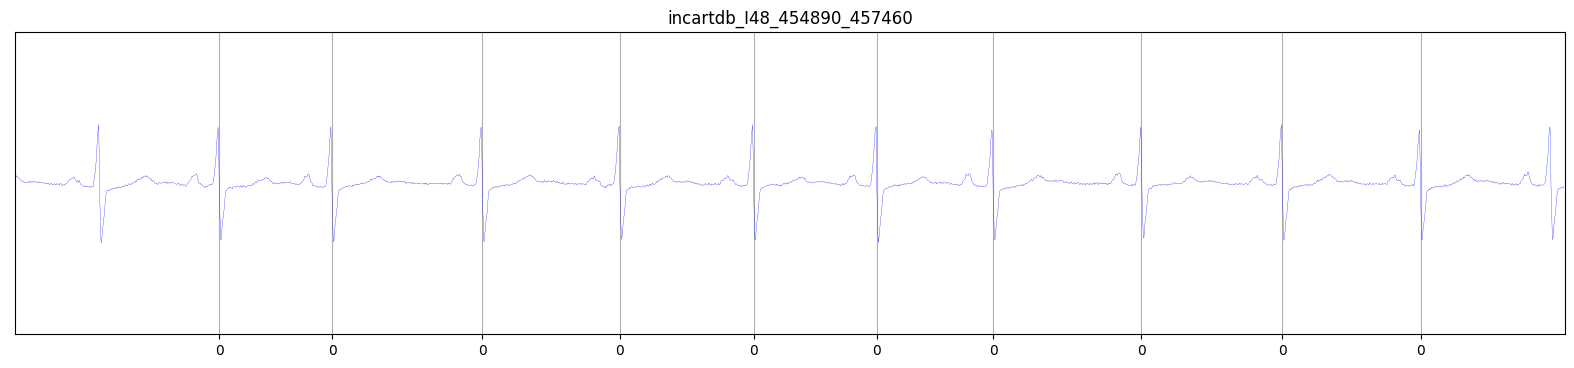

In [0]:

fli = flist[1]
args = fli.split('_')
print(args)
dbi = args[0]
reci = args[1]
fi = int(args[2])
ti = int(args[3])


save_prefix = dbi+'_'+reci+'_'+str(fi)+'_'+str(ti)    # name = dbname_rec_fi_ti

vinfo = np.load(os.path.join(global_datadir,fli))

print(vinfo)
my_db = all_db[dbi]
my_rec = my_db.get_record(reci)
manual_gain=1/my_rec.gain
#print('gain='+str(my_rec.gain))
signalmed2 = np.multiply(my_rec.load_data(g_MED_POSTFIX)[fi:ti],[manual_gain])

fwid = ((ti-fi)/my_db.srate) * x_scale * m_scale
lysize = (fwid,fhig*1) #secods

plt.figure(0,figsize=lysize, frameon=False, dpi=100)

plt.ylim(fylims)
plt.xlim((0,ti-fi))
plt.axes().get_yaxis().set_visible(False)
plt.grid(axis='x')

plt.plot(signalmed2,color='blue',linewidth=0.2)
plt.xticks(vinfo[:,0],vinfo[:,1])
plt.title(save_prefix)
